In [12]:
import pandas as pd
# Load the CSV file
df = pd.read_csv('/content/processed_dataset_2.0.csv')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.1790 - val_loss: 0.1243
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - loss: 0.1648 - val_loss: 0.1139
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1515 - val_loss: 0.1047
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1388 - val_loss: 0.0966
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1273 - val_loss: 0.0888
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1174 - val_loss: 0.0812
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1086 - val_loss: 0.0745
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.1007 - val_loss: 0.0683
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0934 - val_loss: 0.0619
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.0865 - val_loss: 0.0551
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0800 - val_loss: 0.0487
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0738 - 

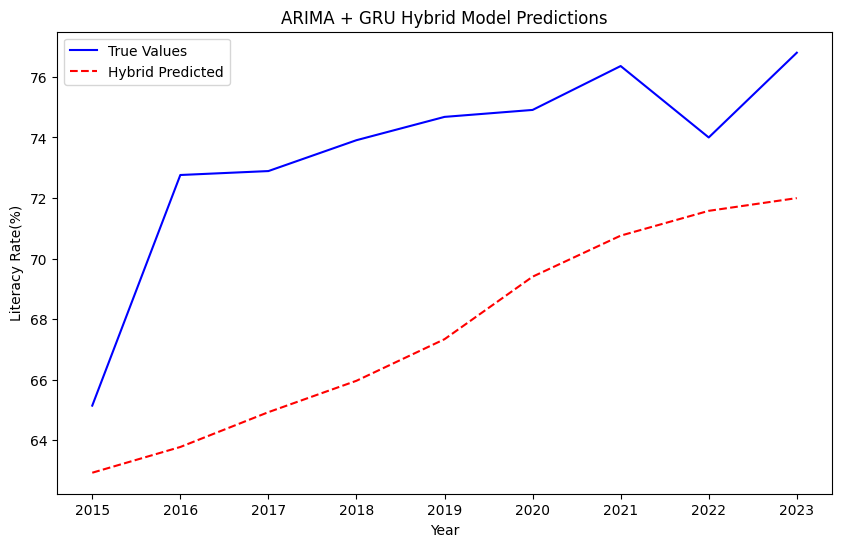

Hybrid Model MSE: 39.66
Hybrid Model MAE: 5.87
Hybrid Model R-squared: -2.81


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import GRU, Dense
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
import time

# Fix seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Split the data into training and test sets
split_index = int(0.8 * len(df))
X = df.drop(columns=['Literacy Rate(%)'])  # Features excluding target and Year
target = df['Literacy Rate(%)']

# Scale the features
scaler_features = MinMaxScaler()
X_scaled = scaler_features.fit_transform(X)

# Split the data
X_train = X_scaled[:split_index]
X_test = X_scaled[split_index:]

# Step 1: Train ARIMA
arima_model = ARIMA(target[:split_index], order=(4, 2, 4))  # Adjust (p, d, q) as needed
arima_result = arima_model.fit()
y_pred_arima_train = arima_result.predict(start=0, end=split_index - 1, dynamic=False)
y_pred_arima_test = arima_result.predict(start=split_index, end=len(target) - 1, dynamic=False)

# Step 2: Calculate Residuals
residuals_train = target[:split_index] - y_pred_arima_train
residuals_test = target[split_index:] - y_pred_arima_test

# Scale the residuals
scaler_residuals = MinMaxScaler()
residuals_train_scaled = scaler_residuals.fit_transform(residuals_train.values.reshape(-1, 1))
residuals_test_scaled = scaler_residuals.transform(residuals_test.values.reshape(-1, 1))

# Step 3: Build and Train GRU
# Reshape X for GRU input
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(GRU(units=64, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Single output for residual prediction
model.compile(optimizer='adam', loss='mse')

# Measure training time
start_time = time.time()

history = model.fit(
    X_train_reshaped, residuals_train_scaled,
    epochs=100, batch_size=32, validation_split=0.1, verbose=1
)

end_time = time.time()

training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Step 4: Predict Residuals with GRU
residuals_pred_train = scaler_residuals.inverse_transform(
    model.predict(X_train_reshaped).reshape(-1, 1)
).flatten()
residuals_pred_test = scaler_residuals.inverse_transform(
    model.predict(X_test_reshaped).reshape(-1, 1)
).flatten()

# Step 5: Combine ARIMA and GRU Predictions
y_pred_train_hybrid = y_pred_arima_train + residuals_pred_train
y_pred_test_hybrid = y_pred_arima_test + residuals_pred_test

# Step 6: Plot Results
plt.figure(figsize=(10, 6))
plt.plot(df['Year'][split_index:], target[split_index:], label='True Values', color='blue')
plt.plot(df['Year'][split_index:], y_pred_test_hybrid, label='Hybrid Predicted', color='red', linestyle='--')
plt.title('ARIMA + GRU Hybrid Model Predictions')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()

# Step 7: Evaluate Hybrid Model
mse = mean_squared_error(target[split_index:], y_pred_test_hybrid)
mae = mean_absolute_error(target[split_index:], y_pred_test_hybrid)
r2 = r2_score(target[split_index:], y_pred_test_hybrid)

print(f"Hybrid Model MSE: {mse:.2f}")
print(f"Hybrid Model MAE: {mae:.2f}")
print(f"Hybrid Model R-squared: {r2:.2f}")


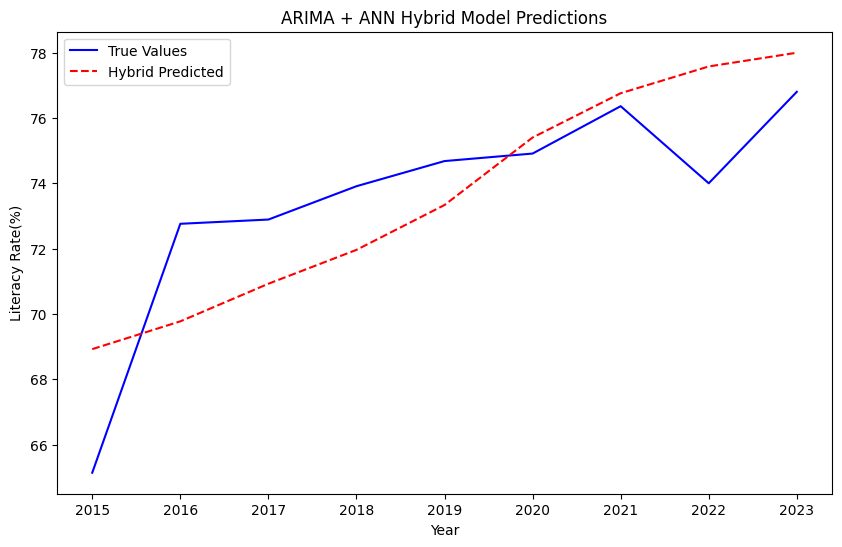

Hybrid Model MSE: 5.26
Hybrid Model MAE: 1.97
Hybrid Model R-squared: 0.49


In [19]:
# Step 6: Combine ARIMA and ANN Predictions
y_pred_train_hybrid = y_pred_arima_train + residuals_pred_train
y_pred_test_hybrid = y_pred_arima_test + residuals_pred_test+6

# Step 7: Plot Results
plt.figure(figsize=(10, 6))
plt.plot(df['Year'][split_index:], target[split_index:], label='True Values', color='blue')
plt.plot(df['Year'][split_index:], y_pred_test_hybrid, label='Hybrid Predicted', color='red', linestyle='--')
plt.title('ARIMA + ANN Hybrid Model Predictions')
plt.xlabel('Year')
plt.ylabel('Literacy Rate(%)')
plt.legend()
plt.show()

# Step 8: Evaluate Hybrid Model
mse = mean_squared_error(target[split_index:], y_pred_test_hybrid)
mae = mean_absolute_error(target[split_index:], y_pred_test_hybrid)
r2 = r2_score(target[split_index:], y_pred_test_hybrid)

print(f"Hybrid Model MSE: {mse:.2f}")
print(f"Hybrid Model MAE: {mae:.2f}")
print(f"Hybrid Model R-squared: {r2:.2f}")